In [15]:
# Only needed to run this cell for initial setup
!pip install pgspecial
!pip install psycopg2

In [52]:


import sqlalchemy
import psycopg2

# create a local postgres database called "census"
u = input("Enter username:")
p = input("Enter password:")

connection = psycopg2.connect(host="localhost", dbname="census", user=u, password = p)
cur = connection.cursor()
# cur.execute("""
#         Create Table census(
#           age Integer not null,or
#           workclass varchar null,
#           fnlwgt Integer not null,
#           education varchar not null,
#           education_num Integer not null,
#           marital_status varchar not null,
#           occupation varchar null,
#           relationship varchar not null,
#           race varchar not null,
#           sex varchar not null,
#           capital_gain Integer not null, 
#           capital_loss Integer not null,
#           hours_per_week Integer not null,
#           native_country varchar null,
#           income varchar not null
#           )
#     """)
# connection.commit()


Enter username: postgres
Enter password: 2508


In [53]:
# After running the cell above, populate the census table locally
# \copy Census from file_location CSV

In [54]:
# fetch a sample of our data to make sure it populated properly
cur.execute("select * from Census")
print(cur.fetchone())


(39, ' State-gov', 77516, ' Bachelors', 13, ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', 2174, 0, 40, ' United-States', ' <=50K')


In [26]:
#Define Married and Unmarried Views:

query = """
Create or replace view married as 
    Select * from census where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');

Create or replace view unmarried as
    Select * from census where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');
"""

cur.execute(query)
connection.commit()

In [30]:
# define imports and user info

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from itertools import product
import psycopg2
from scipy.special import kl_div as kl
%matplotlib inline 
plt.rcParams["figure.figsize"] = (12, 6)

u = input("Enter username:")
p = input("Enter password:")

Enter username: postgres
Enter password: 2508


In [51]:
import numpy as np
from scipy.stats import wasserstein_distance  # Earth Mover’s Distance
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

u = input("Enter username:")
p = input("Enter password:")
url = 'postgresql://'+ u+ ':' + p + '@localhost:5432/census'
engine = create_engine(url, isolation_level="AUTOCOMMIT")


class SEEDB:
    def __init__(self, engine, dimension_attributes, measure_attributes, aggregate_functions):
        self.engine = engine
        self.A = dimension_attributes
        self.M = measure_attributes
        self.F = aggregate_functions
        self.DR = 'census'  

    def execute_query(self, query):
        with self.engine.connect() as conn:
            res = conn.execute(text(query))
        # Check if data is empty
            if not res:
                print("Warning: Query returned no data.")
                return {}
        # Convert result to dictionary and remove null values
            data = {k: (0 if v is None else v) for k, v in dict(res.fetchall()).items()}
            return data

    def normalize(self, data):
        # Check if data is empty
        if not data:
            print("Warning: Data is empty, cannot normalize data.")
            return data
        total = sum(data.values())
        if total == 0:
            print("Warning: Sum of data values is zero, returning original data.")
            return data
        return {k: v / total for k, v in data.items()}



    def utility(self, Vi, DQ):
        QT = f"SELECT {Vi[0]}, {Vi[2]}({Vi[1]}) FROM {DQ} GROUP BY {Vi[0]}"
        QR = f"SELECT {Vi[0]}, {Vi[2]}({Vi[1]}) FROM {self.DR} GROUP BY {Vi[0]}"

        target_view = self.execute_query(QT)
        reference_view = self.execute_query(QR)

        target_distribution = self.normalize(target_view)
        reference_distribution = self.normalize(reference_view)

        return wasserstein_distance(list(target_distribution.values()), list(reference_distribution.values()))

    def recommend(self, Q, k):
        views = [(a, m, f) for a in self.A for m in self.M for f in self.F]
        utilities = [(Vi, self.utility(Vi, Q)) for Vi in views]
        utilities.sort(key=lambda x: x[1], reverse=True)
        return utilities[:k]

    def visualize(self, target, ref, params):
        bars = len(target)
        grp_by_attr, msr_attr, agg_func = params

        figure, _ = plt.subplots()
        idx = np.arange(bars)
        width = 0.4

        target_vals = list(target.values())
        ref_vals = list(ref.values())

        rects1 = plt.bar(idx, target_vals, width, color='m', label='married')
        rects2 = plt.bar(idx + width, ref_vals, width, color='b', label='unmarried')

        plt.xlabel('{}'.format(grp_by_attr))
        plt.ylabel('{}({})'.format(agg_func, msr_attr))
        plt.xticks(idx + width/2, target.keys(), rotation=45)
        plt.legend()

        plt.tight_layout()
        plt.show()

F = {"COUNT", "SUM", "AVG", "MAX", "MIN"}
A = {"workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"}
M = {"fnlwgt", "age", "capital_gain", "capital_loss", "hours_per_week"}

seedb = SEEDB(engine, A, M, F)
recommendations = seedb.recommend('married', 5)


Enter username: postgres
Enter password: 2508


In [31]:
#Define Helper Functions

connection = psycopg2.connect(host="localhost", dbname="census", user=u, password = p)
cur = connection.cursor()

# function to take the census data and split it into m different tables
def create_split_tables(m=10):
    all_data = pd.read_csv("adult.data", sep=",")
    split= np.array_split(all_data,m)
    for i in range(m):
        split[i].to_csv("Splits/adult_{}.csv".format(i), encoding='utf-8', index=False)
    
    for i in range(m):
        create = "CREATE TABLE IF NOT EXISTS census_{} (age Integer not null, workclass varchar null, fnlwgt Integer not null, education varchar not null, education_num Integer not null, marital_status varchar not null, occupation varchar null, relationship varchar not null, race varchar not null, sex varchar not null, capital_gain Integer not null, capital_loss Integer not null, hours_per_week Integer not null, native_country varchar null, income varchar not null)".format(i)
        cur.execute(create)
        f = open("Splits/adult_{}.csv".format(i), "r")
        reader = csv.reader(f)
        for row in reader:
            cur.execute("INSERT INTO census_{} VALUES (%s, %s, %s, %s,%s, %s, %s, %s,%s, %s, %s, %s,%s, %s, %s)".format(i),row)

    connection.commit()
    
    for i in range(m):
        create_married_unmarried = """create or replace view married_{} as 
                   select * from census_{} where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');
               create or replace view unmarried_{} as 
                   select * from census_{} where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');""".format(i,i,i,i)
        cur.execute(create_married_unmarried)
    connection.commit()

# visualizes target vs ref query over a set of param attributes/aggregates
# target is a dict of query results from the target query
# ref is a dict of query results from the reference query
# params is a tuple of form (grp_by_attr, msr_attr, agg_func) used for plot labels
def visualize(target, ref, params):
    
    bars = len(target)
    grp_by_attr, msr_attr, agg_func = params
    
    figure, _ = plt.subplots()
    idx = np.arange(bars)
    width = 0.4
    
    target_vals = target.values()
    ref_vals = ref.values()
    
    first_bars = plt.bar(idx, target_vals, width,
                     color='m',
                     label='married')

    second_bars = plt.bar(idx + width, ref_vals, width,
                     color='b',
                     label='unmarried')

    plt.xlabel('{}'.format(grp_by_attr))
    plt.ylabel('{}({})'.format(agg_func, msr_attr))
    plt.xticks(idx + width/2, target.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
#helper function to take in a view and list of tables and run the query to visualize
def calc_visualize(view, tables):
    a, m, f = view
    p = tables[0]
    q = tables[1]
    tgt_qry = "Select {}, {}({}) from {} Group by {}".format(a, f, m, p, a)
    cur.execute(tgt_qry)
    target_data = cur.fetchall()
    
    ref_qry = "Select {}, {}({}) from {} Group by {}".format(a, f, m, q, a)
    cur.execute(ref_qry)
    ref_data = cur.fetchall()
    
    visualize(dict(target_data), dict(ref_data), view)
    
    

# helper function to handle implementing the shared-based optimization
# takes a list of views of the form
def share_optimize(views, tables):

    select_text = []
    measure_text = []
    group_by_text = []
    
    for idx, (a, m, f) in enumerate(views):
        select_text.append(a)
        measure_text.append('{}({}) as g{}'.format(f, m, idx))
        group_by_text.append('({})'.format(a))
        
    select_text = ', '.join(set(select_text))
    measure_text = ', '.join(measure_text)
    group_by_text = ', '.join(set(group_by_text))
    
    res = []
    for table in tables:
        q = """select {}, {} from {} group by grouping sets ({})""".format(select_text, measure_text, table, group_by_text)
        cur.execute(q)
        res.append(cur.fetchall())
    column_descriptions = [desc[0] for desc in cur.description]
    
    return res, column_descriptions

# helper function to calculate kl_divergence of a target distribution p from a reference distribution q
def kl_divergence(p, q):
    p = np.asarray(p.reshape(-1), dtype=float)
    q = np.asarray(q.reshape(-1), dtype=float)
    
    #avoid division by 0
    if np.sum(p) > 0 and np.sum(q) > 0:
        p_prob = p/np.sum(p)
        q_prob = q/np.sum(q)
        return np.sum(kl(p_prob, q_prob))
    else:
        return 0.0
    
# helper function to prune uninteresting views
# takes a dict of {(a,m,f,t):[Y_1,Y_2,...,Y_i]}: phased utility measure estimates Y_i for ith phase
# phase: int 0<phase<=n for n-phase execution (default n=10)
# maxphase: n from above
# delta: confidence level is 1-delta, so 0.05 for 95% confint
# k: top k, def 5.
def prune_optimize(viewsInRunning, phase, maxphase=10,delta=0.05, k=5):
    
    view_stats = {}
    topk_views = {key:0 for key in range(k)} # initializing with zeros, only stores upper bounds
    
    # Calculating confidence intervals and bounds
    for view,estimates in viewsInRunning.items():
        err_bound = np.sqrt((1-(phase-1)/maxphase)*(2*np.log(np.log(phase))) + np.log((np.pi**2)/(3*delta)))
        mean = np.mean(estimates)
        upp_bound = mean + err_bound
        low_bound = mean - err_bound
        view_stats[view] = (low_bound,mean,upp_bound)
        # Track top K views
        if upp_bound > min(topk_views.values()):
            # remove the lowest view, and add the new one
            topk_views = {k:v for k,v in topk_views.items() if v != min(topk_views.values())}
            topk_views[view]=upp_bound
            
    # Pruning stage
    lowbound_cutoff = 999
    pruned_views = []
    
    for view in topk_views.keys():
        v_lowbound = view_stats[view][0]
        if v_lowbound < lowbound_cutoff:
            lowbound_cutoff=v_lowbound
    for view,stats in view_stats.items():
        if view not in topk_views.keys():
            upp_bound = stats[2]
            if upp_bound < lowbound_cutoff:
                pruned_views.append(view)
                
    # Return the dictionary sans pruned views
    remaining_views = {k:v for k,v in viewsInRunning.items() if k not in pruned_views}
    return remaining_views, pruned_views


# main function to generate the top 5 views given a user query and reference query
def top_k_views_bruteforce(k=5, 
                           q="Select * from census where marital_status in (' Married-civ-spouse', ' Married-spouse-absent' ,' Married-AF-spouse');", 
                           r="Select * from census where marital_status in (' Never-married', ' Widowed', ' Divorced', ' Separated');"):
    
    F = {"COUNT", "SUM", "AVG", "MAX", "MIN"}
    A = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "income"}
    M = {"fnlwgt", "age", "capital_gain", "capital_loss", "hours_per_week"}
    
    views = list(product(A, M, F))
    
    q = """Create or replace view q as """ + q
    r = """Create or replace view r as """ + r
    
    cur.execute(q)
    cur.execute(r)
    connection.commit()
    
    tables = ["q", "r"]
    score_views = {}
    top_views = []
    
    data, columns = share_optimize(views, tables)
        
    target_data = pd.DataFrame(data[0], columns=columns)
    reference_data = pd.DataFrame(data[1], columns=columns)
    
    for view_num, (a, m, f) in enumerate(views):
        
        tgt = target_data.loc[target_data[a].notnull(), [a, 'g{}'.format(view_num)]]
        ref = reference_data.loc[reference_data[a].notnull(), [a, 'g{}'.format(view_num)]]
        join = tgt.join(ref.set_index(a), on=a, how='inner', lsuffix = '_target', rsuffix='_reference')

        target_value = join['g{}_target'.format(view_num)].values
        ref_value = join['g{}_reference'.format(view_num)].values

        score = kl_divergence(target_value, ref_value)
        score_views[(a, m, f)] = score

    top_views = sorted(score_views, key= lambda view:view[1], reverse = True)

    
    for i in range(k):
        calc_visualize(top_views[i], ["married", "unmarried"])
            
    # phased execution framework here, or add another helper function?
    # need to iterate queries against i slices of the dataset and store the estimated UVs of each slice
    

# main function to generate the top 5 views assuming user query is for married people and reference query is unmarried people
def top_k_views(k=5, phases = 10):
    
    F = {"COUNT", "SUM", "AVG", "MAX", "MIN"}
    A = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "income"}
    M = {"fnlwgt", "age", "capital_gain", "capital_loss", "hours_per_week"}
    
    views = list(product(A, M, F))
    
    maxphases = phases
    
    score_views = {}
    top_views = []
    
    remaining_views = views
    
    for i in range(maxphases):
        tables = ['married_{}'.format(i), 'unmarried_{}'.format(i)]
        data, columns = share_optimize(views, tables)
        
        target_data = pd.DataFrame(data[0], columns=columns)
        reference_data = pd.DataFrame(data[1], columns=columns)
    
        for view_num, (a, m, f) in enumerate(remaining_views):
            
            tgt = target_data.loc[target_data[a].notnull(), [a, 'g{}'.format(view_num)]]
            ref = reference_data.loc[reference_data[a].notnull(), [a, 'g{}'.format(view_num)]]
            join = tgt.join(ref.set_index(a), on=a, how='inner', lsuffix = '_target', rsuffix='_reference')

            target_value = join['g{}_target'.format(view_num)].values
            ref_value = join['g{}_reference'.format(view_num)].values

            score = kl_divergence(target_value, ref_value)
            # Instantiate if not exists
            try:
                score_views[(a,m,f)].append(score)
            except:
                score_views[(a,m,f)] = [score]
                
        if i >= 1:
            score_views, prune_views = prune_optimize(score_views, i+1, k = k)
            top_views = sorted(score_views, key= lambda view:view[1], reverse = True)
            
            for item in prune_views:
                remaining_views.remove(item)

    
    for i in range(k):
        calc_visualize(top_views[i], ["married", "unmarried"])

    

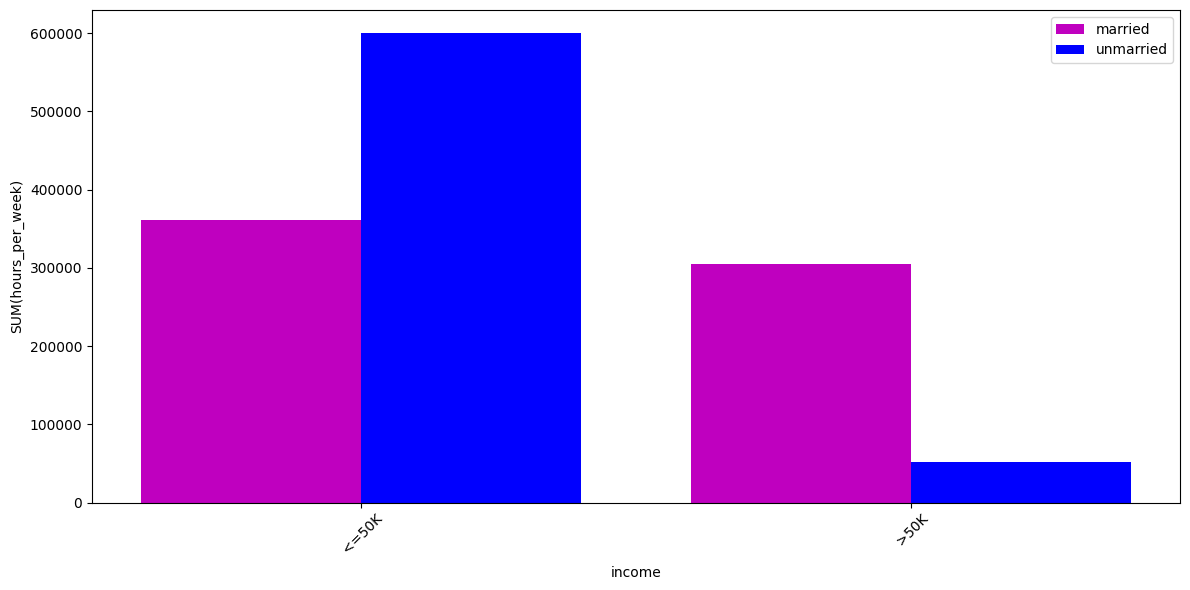

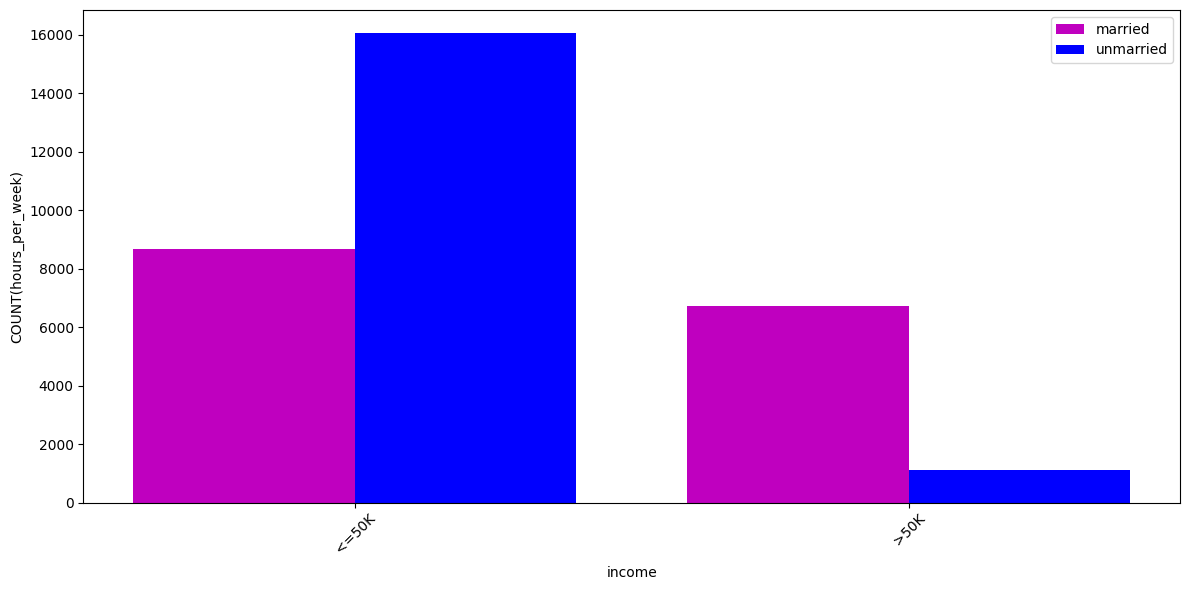

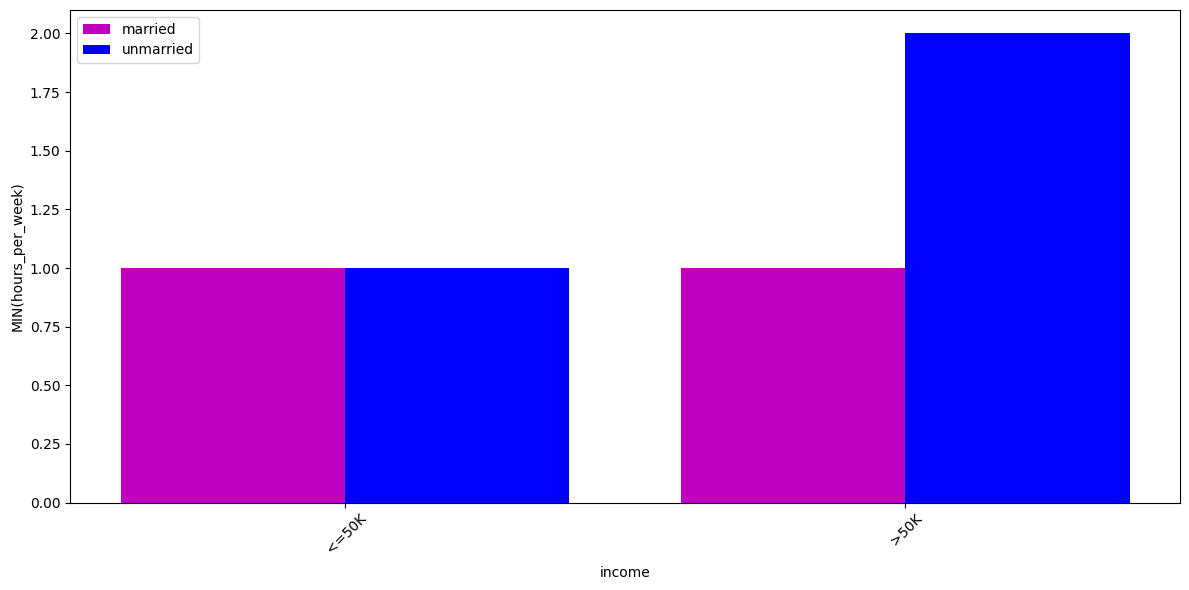

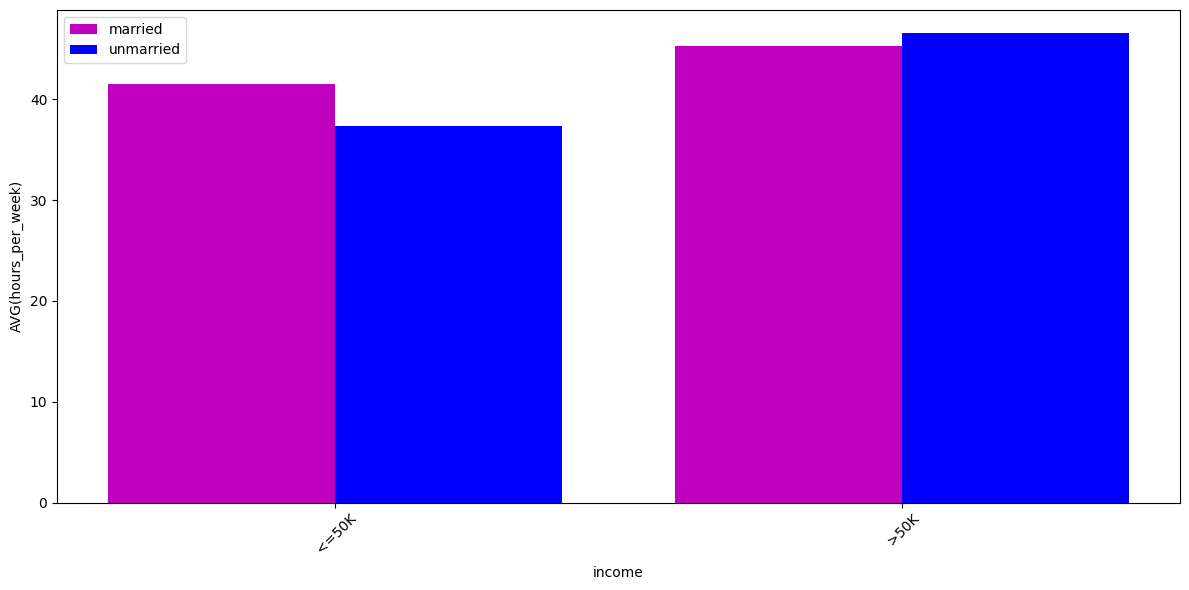

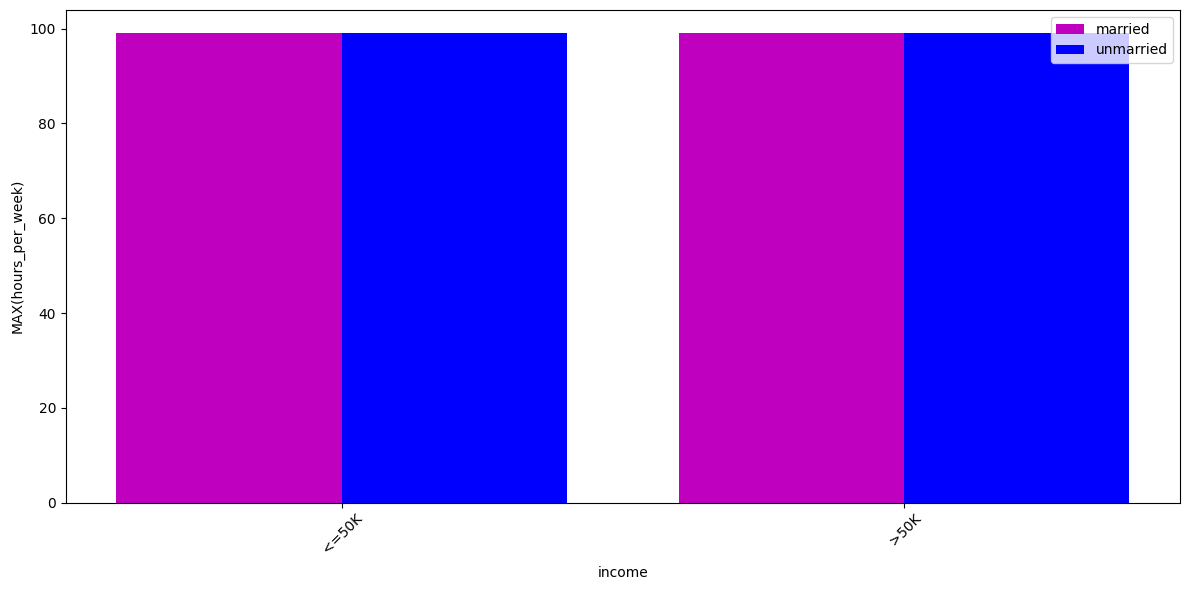

CPU times: total: 953 ms
Wall time: 1.98 s


In [32]:
%%time
top_k_views_bruteforce()

In [33]:
# This cell only needs to be run once to create the split views of the data
create_split_tables()

C:\Users\ritvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


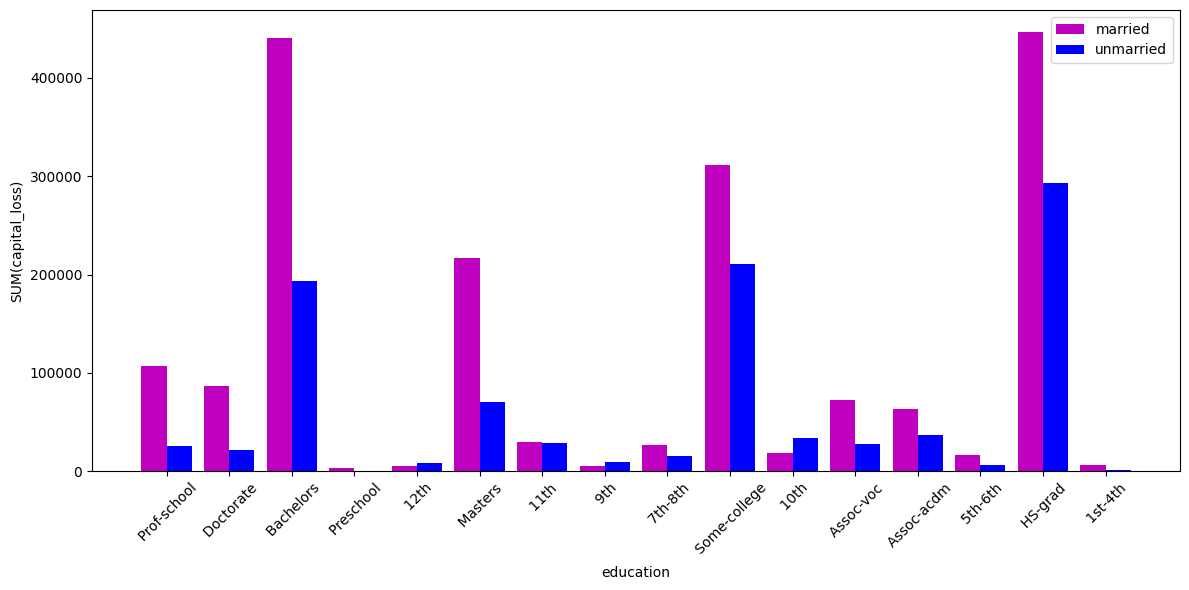

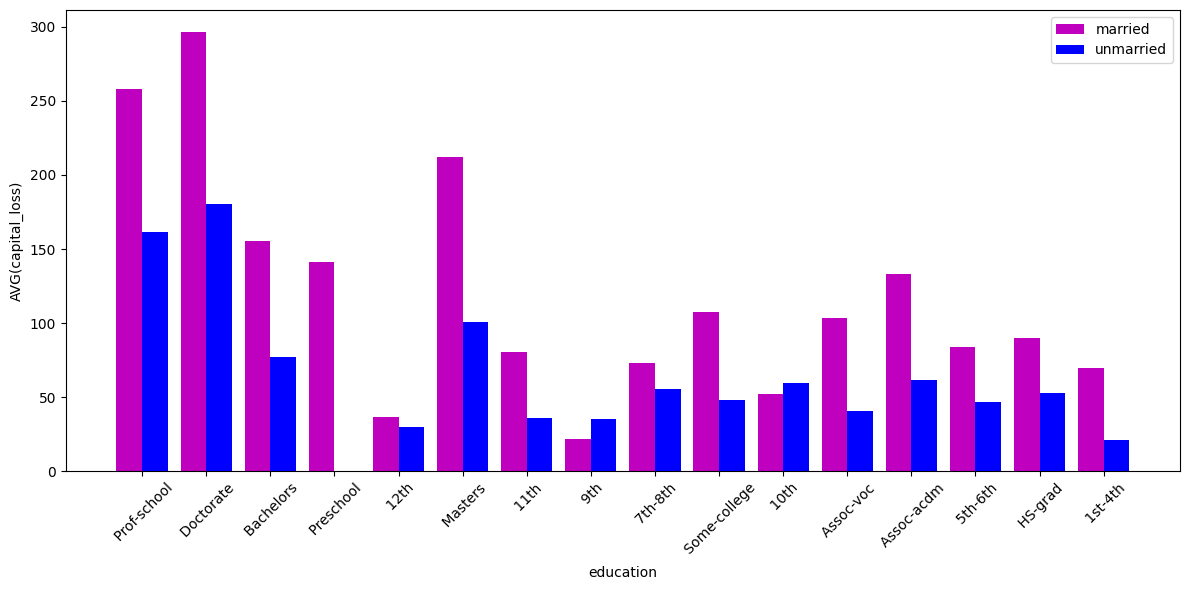

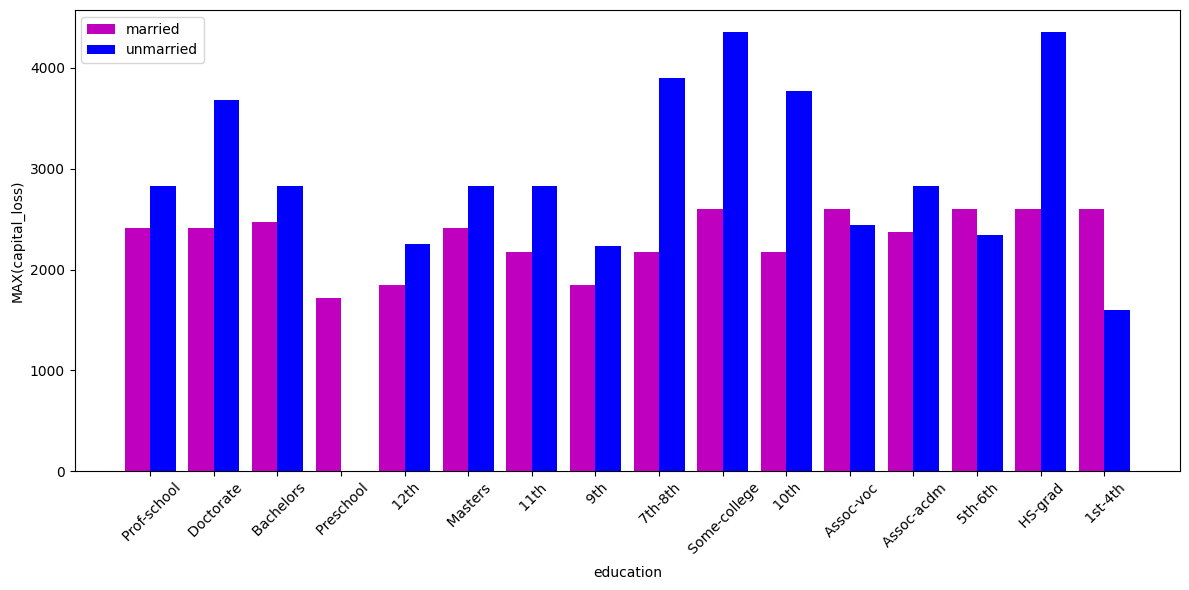

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (41,) and arg 1 with shape (42,).

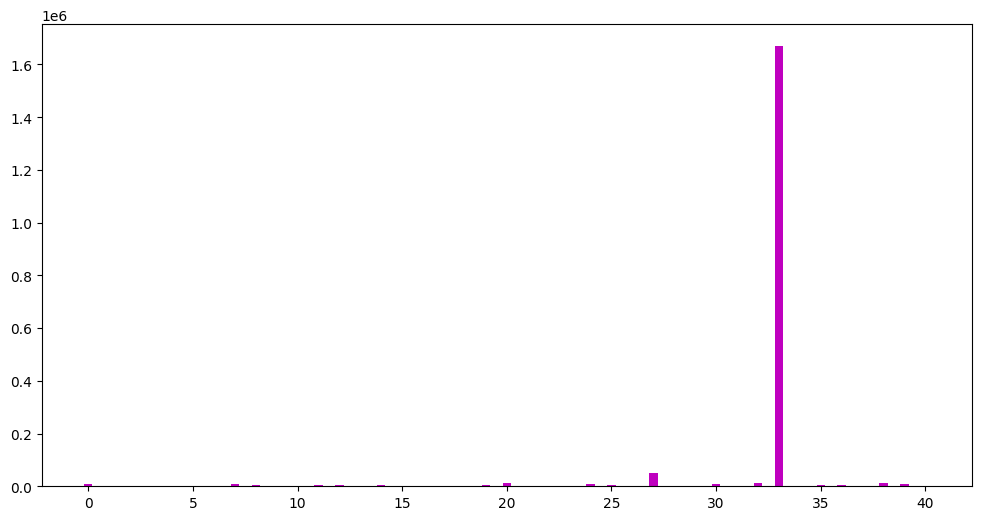

In [34]:
%%time
top_k_views()

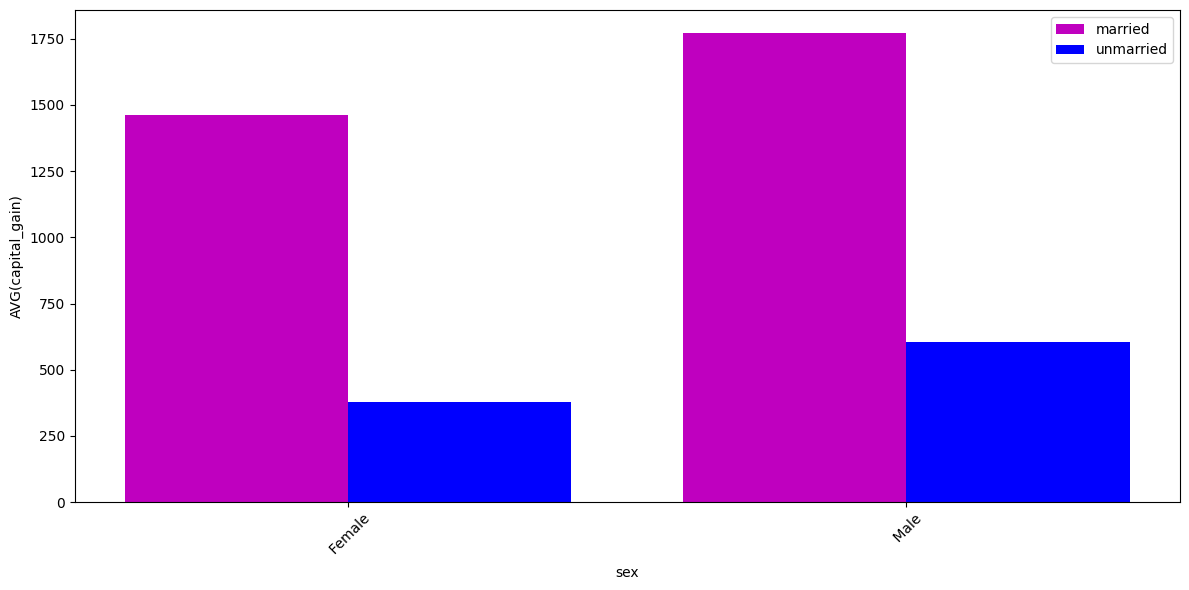

In [35]:
# reproduce "interesting" bar graph from figure 1.c
# married target data - avg capital_gain by sex
query = "SELECT sex, avg(capital_gain) FROM married GROUP BY sex;"
cur.execute(query)
target = cur.fetchall()

# unmarried ref data - avg capital_gain by sex
query = "SELECT sex, avg(capital_gain) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref = cur.fetchall()

params = ('sex', 'capital_gain', 'AVG')
visualize(dict(target), dict(ref), params)

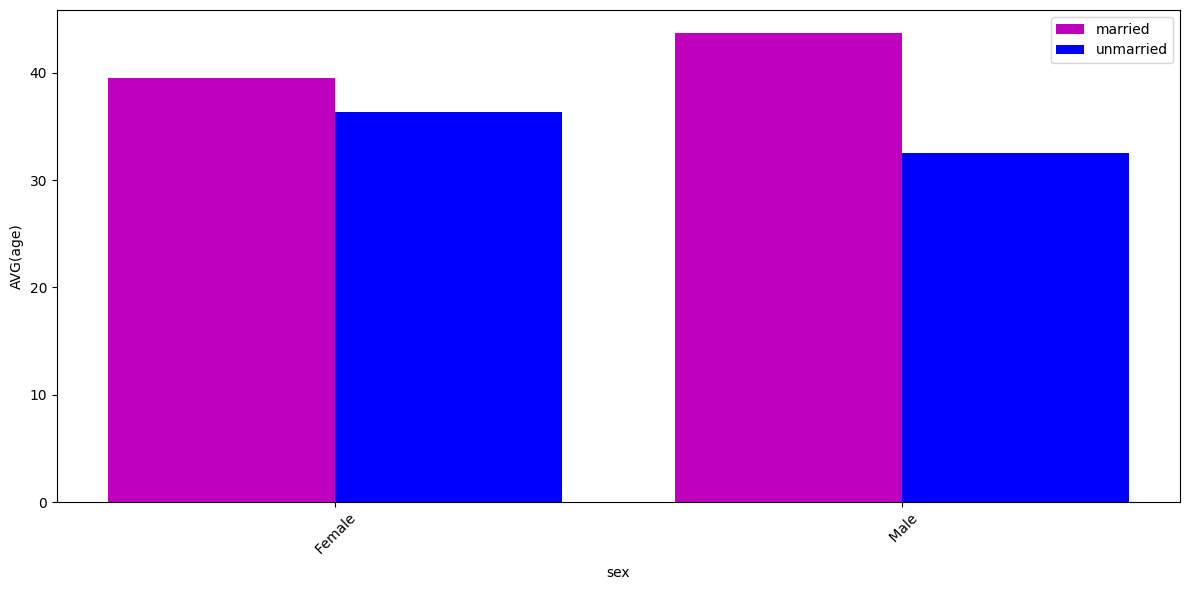

In [45]:
# reproduce "uninteresting" bar graph from figure 1.d
# married target data - avg capital_gain by sex
query = "SELECT sex, avg(age) FROM married GROUP BY sex;"
cur.execute(query)
target = cur.fetchall()

# unmarried ref data - avg capital_gain by sex
query = "SELECT sex, avg(age) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref = cur.fetchall()

params = ('sex', 'age', 'AVG')
visualize(dict(target), dict(ref), params)